In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os
import matplotlib.pyplot as plt

In [3]:


# ResNet18을 위해 최대한 간단히 수정한 BasicBlock 클래스 정의
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, with_BN, stride=1):
        super(BasicBlock, self).__init__()
        self.with_BN = with_BN

        # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        if with_BN: # 배치 정규화(batch normalization)를 사용하는 경우
            self.bn1 = nn.BatchNorm2d(planes) 

        # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        if with_BN: # 배치 정규화(batch normalization)를 사용하는 경우
            self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential() # 단순한 identity mapping인 경우
        if stride != 1: # stride가 1이 아니라면, Identity mapping이 아닌 경우
            modules = [nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False)]
            if with_BN:
                modules.append(nn.BatchNorm2d(planes))
            self.shortcut = nn.Sequential(*modules)

    def forward(self, x):
        if self.with_BN: # 배치 정규화(batch normalization)를 사용하는 경우
            out = F.relu(self.bn1(self.conv1(x)))
            out = self.bn2(self.conv2(out))
        else:
            out = F.relu(self.conv1(x))
            out = self.conv2(out)
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out


# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, with_BN, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.with_BN = with_BN

        # 64개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        if with_BN: # 배치 정규화(batch normalization)를 사용하는 경우
            self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, with_BN, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, with_BN, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, with_BN, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, with_BN, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, with_BN, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, with_BN, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        if self.with_BN: # 배치 정규화(batch normalization)를 사용하는 경우
            out = F.relu(self.bn1(self.conv1(x)))
        else:
            out = F.relu(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# ResNet18 함수 정의
def ResNet18(with_BN):
    return ResNet(BasicBlock, [2, 2, 2, 2], with_BN)

In [5]:
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

Using downloaded and verified file: ./data\cifar-10-python.tar.gz
Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
criterion = nn.CrossEntropyLoss() # 분류(classification) 문제


def train(net, optimizer, epoch, step):
    net.train()
    correct = 0 # 정답을 맞힌 이미지 개수
    total = 0 # 전체 이미지 개수
    steps = [] # 학습 스텝(step)
    losses = [] # 각 스텝에서의 손실(loss)

    for _, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

        steps.append(step)
        losses.append(loss.item())
        step += 1

    return correct / total, steps, losses


def test(net, optimizer, epoch):
    net.eval()
    correct = 0 # 정답을 맞힌 이미지 개수
    total = 0 # 전체 이미지 개수
    loss = 0 # 손실(loss)

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.cuda(), targets.cuda()

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

    return correct / total, loss

In [7]:
print('모델 파라미터를 초기화합니다.')
net = ResNet18(with_BN=False).cuda()
learning_rate = 0.01
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('학습 가능한 총 파라미터 수:', total_params)

모델 파라미터를 초기화합니다.
학습 가능한 총 파라미터 수: 11164362


In [8]:
without_BN_train_accuracies = []
without_BN_steps = []
without_BN_train_losses = []
without_BN_test_accuracies = []
without_BN_test_losses = []

epochs = 20

for epoch in range(0, epochs):
    print(f'[ Epoch: {epoch}/{epochs} ]')
    train_accuracy, steps, train_losses = train(net, optimizer, epoch, len(without_BN_steps))
    without_BN_train_accuracies.append(train_accuracy)
    without_BN_steps.extend(steps)
    without_BN_train_losses.extend(train_losses)
    print(f'Train accuracy = {train_accuracy * 100:.2f} / Train loss = {sum(train_losses)}')

    test_accuracy, test_loss = test(net, optimizer, epoch)
    without_BN_test_accuracies.append(test_accuracy)
    without_BN_test_losses.append(test_loss)
    print(f'Test accuracy = {test_accuracy * 100:.2f} / Test loss = {test_loss}')

[ Epoch: 0/20 ]
Train accuracy = 16.27 / Train loss = 860.4434920549393
Test accuracy = 23.71 / Test loss = 202.2939406633377
[ Epoch: 1/20 ]
Train accuracy = 26.98 / Train loss = 770.7071235179901
Test accuracy = 34.85 / Test loss = 179.4733669757843
[ Epoch: 2/20 ]
Train accuracy = 33.94 / Train loss = 697.6281042098999
Test accuracy = 38.92 / Test loss = 165.8872345685959
[ Epoch: 3/20 ]
Train accuracy = 39.80 / Train loss = 638.6975914239883
Test accuracy = 43.38 / Test loss = 152.3243453502655
[ Epoch: 4/20 ]
Train accuracy = 44.02 / Train loss = 595.4011218547821
Test accuracy = 47.85 / Test loss = 143.699964761734
[ Epoch: 5/20 ]
Train accuracy = 48.66 / Train loss = 552.0805348157883
Test accuracy = 50.91 / Test loss = 134.09837353229523
[ Epoch: 6/20 ]
Train accuracy = 53.28 / Train loss = 507.9480516910553
Test accuracy = 55.71 / Test loss = 121.6473718881607
[ Epoch: 7/20 ]
Train accuracy = 56.98 / Train loss = 469.8922188282013
Test accuracy = 59.86 / Test loss = 111.811141

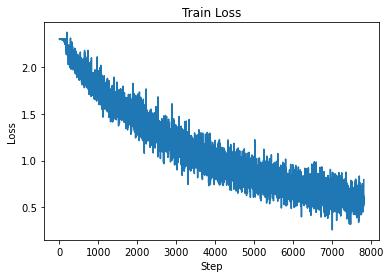

In [9]:
plt.plot(without_BN_steps, without_BN_train_losses)
plt.title('Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

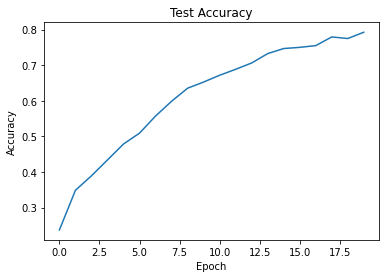

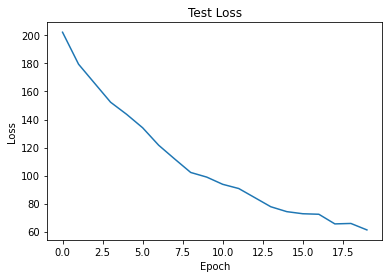

In [10]:
plt.plot([i for i in range(len(without_BN_test_accuracies))], without_BN_test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot([i for i in range(len(without_BN_test_losses))], without_BN_test_losses)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [11]:
print('모델 파라미터를 초기화합니다.')
net = ResNet18(with_BN=True).cuda()
learning_rate = 0.01
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('학습 가능한 총 파라미터 수:', total_params)

모델 파라미터를 초기화합니다.
학습 가능한 총 파라미터 수: 11173962


In [12]:
with_BN_train_accuracies = []
with_BN_steps = []
with_BN_train_losses = []
with_BN_test_accuracies = []
with_BN_test_losses = []

epochs = 20

for epoch in range(0, epochs):
    print(f'[ Epoch: {epoch}/{epochs} ]')
    train_accuracy, steps, train_losses = train(net, optimizer, epoch, len(with_BN_steps))
    with_BN_train_accuracies.append(train_accuracy)
    with_BN_steps.extend(steps)
    with_BN_train_losses.extend(train_losses)
    print(f'Train accuracy = {train_accuracy * 100:.2f} / Train loss = {sum(train_losses)}')

    test_accuracy, test_loss = test(net, optimizer, epoch)
    with_BN_test_accuracies.append(test_accuracy)
    with_BN_test_losses.append(test_loss)
    print(f'Test accuracy = {test_accuracy * 100:.2f} / Test loss = {test_loss}')

[ Epoch: 0/20 ]
Train accuracy = 47.05 / Train loss = 566.6767329573631
Test accuracy = 57.31 / Test loss = 119.26063990592957
[ Epoch: 1/20 ]
Train accuracy = 66.65 / Train loss = 365.8200936317444
Test accuracy = 63.68 / Test loss = 117.18056321144104
[ Epoch: 2/20 ]
Train accuracy = 74.87 / Train loss = 281.7067191004753
Test accuracy = 75.77 / Test loss = 72.29643085598946
[ Epoch: 3/20 ]
Train accuracy = 79.17 / Train loss = 235.49068668484688
Test accuracy = 77.88 / Test loss = 65.83133786916733
[ Epoch: 4/20 ]
Train accuracy = 81.84 / Train loss = 205.49577221274376
Test accuracy = 78.14 / Test loss = 65.81383445858955
[ Epoch: 5/20 ]
Train accuracy = 84.03 / Train loss = 182.55066177248955
Test accuracy = 79.23 / Test loss = 63.921522200107574
[ Epoch: 6/20 ]
Train accuracy = 85.18 / Train loss = 166.29298439621925
Test accuracy = 80.55 / Test loss = 61.3310672044754
[ Epoch: 7/20 ]
Train accuracy = 86.32 / Train loss = 152.76270931959152
Test accuracy = 84.31 / Test loss = 46.

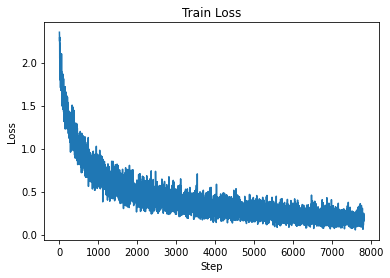

In [13]:
plt.plot(with_BN_steps, with_BN_train_losses)
plt.title('Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

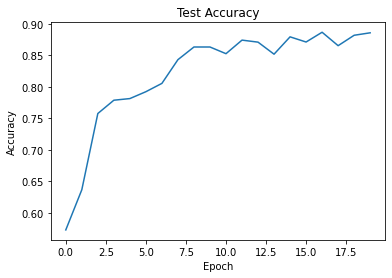

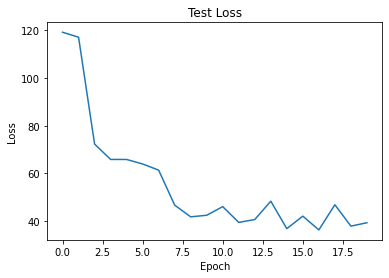

In [14]:
plt.plot([i for i in range(len(with_BN_test_accuracies))], with_BN_test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot([i for i in range(len(with_BN_test_losses))], with_BN_test_losses)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

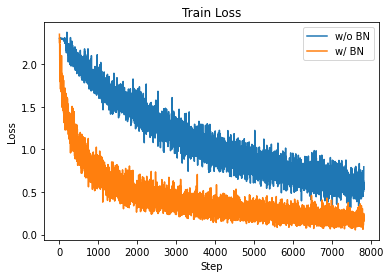

In [15]:
plt.plot(without_BN_steps, without_BN_train_losses)
plt.plot(with_BN_steps, with_BN_train_losses)
plt.title('Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend(['w/o BN', 'w/ BN'])
plt.show()

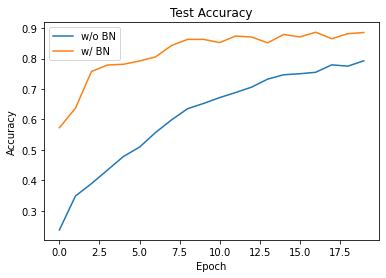

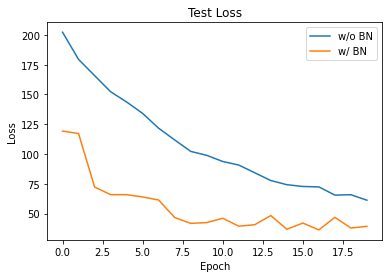

In [16]:
plt.plot([i for i in range(len(without_BN_test_accuracies))], without_BN_test_accuracies)
plt.plot([i for i in range(len(with_BN_test_accuracies))], with_BN_test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['w/o BN', 'w/ BN'])
plt.show()

plt.plot([i for i in range(len(without_BN_test_losses))], without_BN_test_losses)
plt.plot([i for i in range(len(with_BN_test_losses))], with_BN_test_losses)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['w/o BN', 'w/ BN'])
plt.show()